In [1]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
review_data = pd.read_csv('review_final.csv')
user_data = pd.read_csv('filtered_users.csv')

/var/folders/6m/51l9cwxd4px017cch8f2654r0000gn/T/ipykernel_98542/156170387.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  user_data = pd.read_csv('filtered_users.csv')


In [3]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269461 entries, 0 to 269460
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             269461 non-null  object 
 1   name                269459 non-null  object 
 2   review_count        269461 non-null  int64  
 3   yelping_since       269461 non-null  object 
 4   useful              269461 non-null  int64  
 5   funny               269461 non-null  int64  
 6   cool                269461 non-null  int64  
 7   elite               21171 non-null   object 
 8   friends             160194 non-null  object 
 9   fans                269461 non-null  int64  
 10  average_stars       269461 non-null  float64
 11  compliment_hot      269461 non-null  int64  
 12  compliment_more     269461 non-null  int64  
 13  compliment_profile  269461 non-null  int64  
 14  compliment_cute     269461 non-null  int64  
 15  compliment_list     269461 non-nul

### User clustering with time difference and weighted average rating

In [4]:
df_r = review_data.copy()
df_r['date'] = pd.to_datetime(df_r['date'])
df_r.sort_values(by=['user_id', 'date'], inplace=True)
df_c = df_r.groupby('user_id')['date'].diff().dt.days.groupby(df_r['user_id']).mean().reset_index()
df_c.columns = ['user_id', 'time_diff']
df_c.loc[df_c['time_diff'] == 0, 'time_diff'] = np.nan
print(df_c.info())
average_given_rating = df_r.groupby('user_id')['weighted_stars'].mean().reset_index()
df_c = df_c.merge(average_given_rating, on='user_id', how='left')
df_c.rename(columns={'weighted_stars': 'average_given_rating'}, inplace=True)
print(df_c.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269461 entries, 0 to 269460
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    269461 non-null  object 
 1   time_diff  92388 non-null   float64
dtypes: float64(1), object(1)
memory usage: 4.1+ MB
None
                  user_id  time_diff  average_given_rating
0  ---r61b7EpVPkb4UVme5tA       67.0              1.436545
1  --1oopX4BmrQEB_cW2dFVA        NaN              1.172176
2  --1vcleKg-_ORilNx_RaDw        NaN              4.178738
3  --2tyArRmSoyKx5r-FVG0A        3.0              1.811899
4  --2vR0DIsmQ6WfcSzKWigw      187.0              2.651398


#### Handle missing values with mean

In [5]:
df_c['average_given_rating'].fillna(df_c['average_given_rating'].mean(), inplace=True)
df_c['time_diff'].fillna(df_c['time_diff'].mean(), inplace=True)

/var/folders/6m/51l9cwxd4px017cch8f2654r0000gn/T/ipykernel_98542/1369961724.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_c['average_given_rating'].fillna(df_c['average_given_rating'].mean(), inplace=True)
/var/folders/6m/51l9cwxd4px017cch8f2654r0000gn/T/ipykernel_98542/1369961724.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate obje

#### Scale the features

In [6]:
cluster_features = df_c[['average_given_rating', 'time_diff']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_features[['average_given_rating', 'time_diff']])
scaled_cluster_features = pd.DataFrame(scaled_data, columns=['average_given_rating', 'time_diff'])

#### Look for optimal cluster number 

In [7]:
df_matrix = scaled_cluster_features.to_numpy()

# Choose optimal K using Elbow method
cost = []

# Loop across every possible cluster
for cluster in range(1, 10):
    kmeans = KMeans(n_clusters = cluster, random_state = 0)

    # Fit and predict each customer's cluster
    kmeans.fit_predict(df_matrix)

    # Store the cost, with the element's index being the cluster number
    cost.append(kmeans.inertia_)
    print('Cluster initiation: {}'.format(cluster))

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


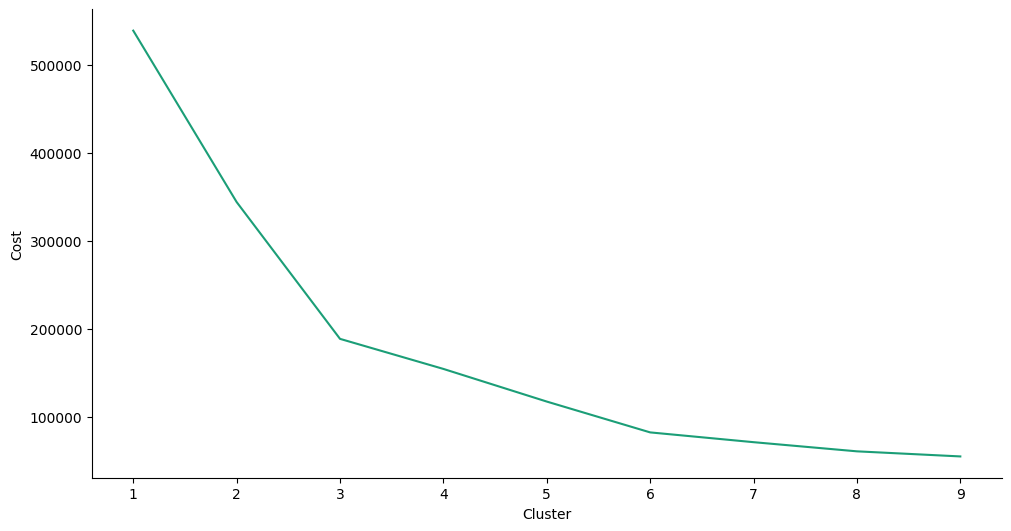

In [8]:
df_cost = pd.DataFrame({'Cluster': range(1, 10), 'Cost':cost})
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  # x series
  xs = series['Cluster']
  # y series
  ys = series['Cost']
  # plot
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')

# Sort by ascending order of cluster
df_sorted = df_cost.sort_values('Cluster', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Cluster')
_ = plt.ylabel('Cost')

In [9]:
# Using the elbow method, the optimal number of clusters to choose is 3.
kmeans = KMeans(n_clusters = 3, random_state = 0)
# Fits the cluster_features and retrieve the Cluster Assignment predictions of each customer
kmeans.fit_predict(df_matrix)

array([0, 0, 1, ..., 1, 0, 0], dtype=int32)

<Axes: xlabel='average_given_rating', ylabel='time_diff'>

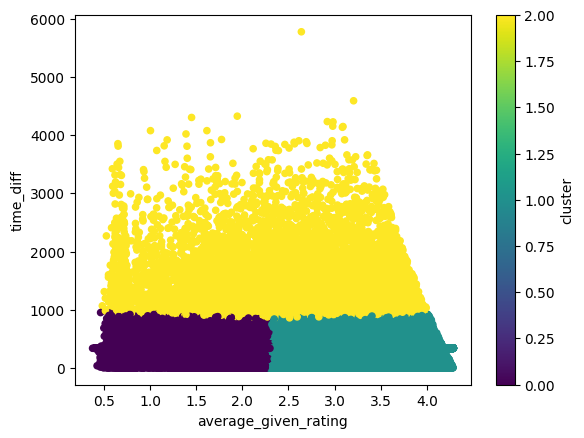

In [10]:
cluster_features['cluster'] = kmeans.labels_
cluster_features.plot(kind='scatter', x='average_given_rating', y='time_diff', c = 'cluster', colormap = 'viridis')

#### Cluster observations
1. Purple (left-bottom): low ratings + frequent actions; they can be critical and active users 
2. Teal (right-bottom): high ratings + frequent actions; they can be positive and active users 
3. Yellow (top): all ratings + infrequent actions; they are inactive regardless of sentiment 

In [27]:
df_c['cluster'] = cluster_features['cluster']
df_c = df_c[['user_id', 'cluster']]
df_c.to_csv('user_cluster.csv', index=False)